done


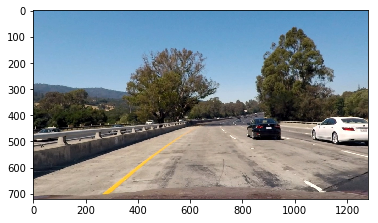

In [37]:
#Camera Calibration

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

#numbers of blocks in chessboard
nx = 9
ny = 6
shape = []
objPoints = [] #3D points in real world space
imgPoints = [] #2D points in image plane
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    #plt.imshow(img)

    #Populate the object points for the chessboard
    objp = np.zeros((nx * ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    #convert image from RGB to Grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]
    #Find the chessboard corners in the image
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    #If corners are found, add object points and image points 
    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objp)
    
        img = cv2.drawChessboardCorners(img,(nx,ny),corners, ret)
  

if(len(objPoints) > 0):
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objPoints, imgPoints,shape,None,None)
    img = mpimg.imread('test_images/test1.jpg')
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    #cv2.imwrite('output_images/test1.jpg', cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    plt.imshow(dst)
print('done')



In [38]:
class LaneDetection():
    def __init__(self):
        self.firstRun = True
        self.laneWindowDetected  = False
        self.recent_xfitted = []
        self.bestx = None
        self.mean_left_fit = []
        self.mean_right_fit = []
        self.current_fit = [np.array([False])]
        self.radius_of_curvature = None
        self.line_base_ps = None
        self.diffs = np.array([0,0,0],dtype='float')
        self.allx = None
        self.ally = None
        self.left_fit = []
        self.right_fit = []
        self.old_warp = None

    
    def weighted_img(self,img, initial_img, a=0.8, b=1., c=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.
        
        `initial_img` should be the image before any processing.
        
        The result image is computed as follows:
        
        initial_img * a + img * b + c
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, a, img, b, c)
    
    def abs_sobel_tresh(self,img,orient = 'x',sobel_kernal=3,mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on sobel operation
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        if orient =='x':
            abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal))
        else:
            abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal))
      
        scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= mag_tresh[0]) & (scaled_sobel <= mag_tresh[1])] = 1
        return binary_output


    def mag_tresh(self,img,sobel_kernal=3,mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on magnintued of image
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal)
        #abs_sobelx = np.absolute(sobelx)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_tresh[0]) & (gradmag <= mag_tresh[1])] = 1
        return binary_output
    
    def dir_tresh(self,img,sobel_kernal=3,mag_tresh=(0,np.pi/2)):
        '''
        utility function to apply tresholding on input image based on direction of image
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal)
        #abs_sobelx = np.absolute(sobelx)
        absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
        binary_output = np.zeros_like(absgraddir)
        binary_output[(absgraddir >= mag_tresh[0]) & (absgraddir <= mag_tresh[1])] = 1
        return binary_output

    def hls_tresh(self,img, layer = 2, mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on hls of image
        '''
            
        hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,layer]
        s_binary = np.zeros_like(s_channel)
        s_binary [(s_channel >= mag_tresh[0]) & (s_channel <= mag_tresh[1])] = 1
        return s_binary
    
    def rgb_tresh(self,img, layer = 1, mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on rgb of image
        '''
            
        r_channel = img[:,:,layer]
        r_binary = np.zeros_like(r_channel)
        r_binary [(r_channel >= mag_tresh[0]) & (r_channel <= mag_tresh[1])] = 1
        return r_binary
            
    def thresholdImage(self,img):
        '''
        utility function to apply pipeline of thresholdin on input image
        '''
        '''   
        ksize = 3
        thr = (0,255)
        gradx = self.abs_sobel_tresh(img, orient='x',sobel_kernal=ksize ,mag_tresh=(20,100))
        grady = self.abs_sobel_tresh(img, orient='y',sobel_kernal=ksize ,mag_tresh=(20,100))
        mag_binary = self.mag_tresh(img, sobel_kernal=ksize ,mag_tresh=(30,100))
        dir_binary = self.dir_tresh(img, sobel_kernal=ksize ,mag_tresh=(.7,1.3))
        s_binary = self.hls_tresh(img,layer =2 , mag_tresh = (170,255))
        l_binary = self.hls_tresh(img,layer =1 , mag_tresh = (140,255))
        h_binary = self.hls_tresh(img,layer =0 , mag_tresh = (170,255))
        
        r_binary = self.rgb_tresh(img,layer = 0, mag_tresh = (220,255))
        g_binary = self.rgb_tresh(img,layer = 1, mag_tresh = (220,255))
        b_binary = self.rgb_tresh(img,layer = 2, mag_tresh = (220,255))
        '''
        HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        
        yellow = cv2.inRange(HSV,(20,100,100),(50,255,255))
        
        sensitivity_1 = 68
        white = cv2.inRange(HSV,(0,0,255-sensitivity_1),(255,20,255))
        
        sensitivity_2 = 60
        HSL = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        white2 = cv2.inRange(HSL,(0,255-sensitivity_2,0),(255,255,sensitivity_2))
        
        white3 = cv2.inRange(img,(200,200,200),(255,255,255))
        
        combined = np.zeros_like(img,dtype = np.uint8)
        #combined[((gradx == 1) & (grady == 1))| ((mag_binary == 1) & (dir_binary == 1)) | ((s_binary == 1) & (l_binary == 1)  ) |((r_binary == 1) & (g_binary ==1)& (b_binary ==1))] = 255
        #combined[((gradx == 1) & (grady == 1))| ((mag_binary == 1) & (dir_binary == 1)) |yellow | white | white2 | white3] =255
        
        combined = yellow | white | white2 | white3
        combined = combined * 255
        
        kernel = np.ones((5,5),np.uint8)
        combined = cv2.morphologyEx(combined,cv2.MORPH_CLOSE,kernel,iterations = 2)
        
        kernel = np.ones((3,3),np.uint8)
        #combined = cv2.dilate(combined,kernel,iterations = 2)
        
        return combined 
    

    def warpImage(self,img):
        '''
        Utility function apply persprective transform on image
        '''
        imshape = (img.shape[1],img.shape[0])
        
        src = np.float32([[190, 720],[585, 455],[1130, 720],[705, 455]])
        dst = np.float32([[300, 720],[300, 100],[1000, 720],[1000, 100]])
        
        self.perspective = cv2.getPerspectiveTransform(src,dst)
        self.invPerspective = cv2.getPerspectiveTransform(dst,src)
        warped = cv2.warpPerspective(img, self.perspective, imshape,flags = cv2.INTER_LINEAR)
     
        return warped
    
    def slideWindow(self,warped,in_img,temp):
        '''
        Utility function to apply sliding window algoritham to find lane
        '''
        histogram = np.sum(warped[:600,:],axis=0)# np.sum(warped[:warped.shape[0]//2,:],axis=0)
    
       
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
       
    
        nwindows = 9
        window_height= np.int(warped.shape[0]/nwindows)
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
    
        margin = 100
        minpix = 50
    
        left_lane_inds = []
        right_lane_inds = []
        
        leftx =  []
        lefty = []
        rightx =[]
        righty =[]
    
        out_img = np.dstack((warped,warped,warped))*255
       
        if (self.laneWindowDetected == True): #& (self.laneDetected == True):
            left_lane_inds = ((nonzerox > (self.prev_left_fit[0] *(nonzeroy ** 2) + self.prev_left_fit[1] * nonzeroy + self.prev_left_fit[2] - margin))&
                              (nonzerox < (self.prev_left_fit[0] * (nonzeroy **2)+ self.prev_left_fit[1]*nonzeroy + self.prev_left_fit[2] + margin)))
            
            right_lane_inds = ((nonzerox > (self.prev_right_fit[0] *(nonzeroy ** 2) + self.prev_right_fit[1] * nonzeroy + self.prev_right_fit[2] - margin))&
            (nonzerox < (self.prev_right_fit[0] * (nonzeroy **2)+ self.prev_right_fit[1]*nonzeroy + self.prev_right_fit[2] + margin)))
            flag = 0
        else:
            self.laneWindowDetected = True
        
            for window in range(nwindows):
                win_y_low = warped.shape[0] - (window + 1) * window_height
                win_y_high = warped.shape[0] - window * window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,255),2)
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
                
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & ( nonzerox >= win_xleft_low)& 
                              (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & 
                               (nonzerox < win_xright_high)).nonzero()[0]
            
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
            
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                    
                    leftx.append(leftx_current)
                    lefty.append(np.int(np.mean(nonzeroy[good_left_inds])))
                    
                if len(good_right_inds) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    
                    rightx.append(rightx_current)
                    righty.append(np.int(np.mean(nonzeroy[good_right_inds])))
        
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            flag = 0
           
    
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        ploty = np.linspace(0,warped.shape[0] - 1 ,warped.shape[0])
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        
        radCheck = False

        if len(righty) <= 0 or len(lefty)  <= 0:
            self.laneWindowDetected = False
            
            self.left_fit = self.prev_left_fit 
            self.right_fit = self.prev_right_fit
            if 0 == 1:
                plt.figure()
                plt.subplot(3,1,1)
                plt.imshow(temp)
                plt.subplot(3,1,2)
                plt.imshow(out_img)
                plt.subplot(3,1,3)
                plt.plot(histogram)
                #return
        else :
            #self.laneWindowDetected = True
            self.left_fit = np.polyfit(lefty,leftx,2)
            self.right_fit = np.polyfit(righty,rightx,2)
            
            left_fit_cr = np.polyfit(lefty * ym_per_pix,leftx * xm_per_pix,2)
            right_fit_cr = np.polyfit(righty * ym_per_pix,rightx * xm_per_pix,2)
           
            y_eval = 0# np.max(ploty)
            left_curverad = ((1 + ((2 * left_fit_cr[0]*y_eval  * ym_per_pix) + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
            right_curverad = ((1 +((2 * right_fit_cr[0]*y_eval * ym_per_pix) + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
            radCheck= (abs(left_curverad - right_curverad) ) < 500
            
            centerOfRoad = abs(left_curverad - right_curverad) / 2
            cameraPos = in_img.shape[1] / 2
            carOffsetFromCenter = (cameraPos - centerOfRoad) * xm_per_pix
     

        if (self.firstRun == True) | (radCheck ):
                self.firstRun = False
                self.cur_left_fit = self.left_fit
                self.cur_right_fit = self.right_fit
                
                self.prev_left_fit = self.left_fit#(self.best_left_fit + self.left_fit) / 2
                self.prev_right_fit= self.right_fit#(self.best_right_fit + self.right_fit) / 2
        else:
                self.cur_left_fit = self.prev_left_fit
                self.cur_right_fit = self.prev_right_fit

        
        left_fitx = (self.cur_left_fit[0] * (ploty**2)) + self.cur_left_fit[1] * ploty + self.cur_left_fit[2]
        right_fitx = (self.cur_right_fit[0] * (ploty ** 2)) + self.cur_right_fit[1] * ploty + self.cur_right_fit[2]
      
        #for debug
        if 0 == 1:
            
            window_img = np.zeros_like(out_img)
            out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
            out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]
            
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
            left_line_pts = np.hstack((left_line_window1,left_line_window2))
            
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin,ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
            right_line_pts = np.hstack((right_line_window1,right_line_window2))
            
            cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
            cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
            result0 = cv2.addWeighted(out_img,1,window_img,0.3,0)
            plt.figure();
            #plt.subplot(2,1,2)
            plt.imshow(result0)
            
            plt.plot(left_fitx,ploty,color='green',linewidth = 3)
            plt.plot(right_fitx,ploty,color='green',linewidth = 3)
            cv2.imwrite("output_images/color_fit_lines.jpg",cv2.cvtColor(result0,cv2.COLOR_RGB2BGR) )
            
        ##
        pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        lane_middle = int((right_fitx[719] - left_fitx[719])/2.) + left_fitx[719]
        
        leng = 3.66/2
        if(lane_middle - 640 > 0):
            mag = ((lane_middle - 640) / 640.* leng)
            carOffsetFromCenter = ("Right",mag)
        else:
            mag = ((lane_middle-640)/640.*leng)*-1
            carOffsetFromCenter = ("Left",mag)
        
        warp_zero= np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
        cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))
        
        if(self.old_warp == None ):
            self.old_warp = color_warp
            
        a = self.old_warp
        b = color_warp
        
        ret = cv2.matchShapes(a[:,:,1],b[:,:,1],1,0.0)
        
        
        if(ret > 0.045):
           color_warp = self.old_warp
            
        self.old_warp = b #store for next round 
        
    
        invWarp = cv2.warpPerspective(color_warp,self.invPerspective,(warped.shape[1],warped.shape[0]))
        result = self.weighted_img(invWarp,in_img,1.0,0.3,0)
        cv2.putText(result,'Left Curvature = %.2f'%(left_curverad),(40,40),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Right Curvature = %.2f'%(right_curverad),(40,80),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Car offset by %.2f towards %s'%(carOffsetFromCenter[1],carOffsetFromCenter[0]),(40,120),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        return result
    
        
    def processImage(self,image):
        self.img = image
        self.undistImg = cv2.undistort(image,mtx,dist,None,mtx)
        warped = self.warpImage(self.undistImg)
        combinedImage = self.thresholdImage(warped)
        slided = self.slideWindow(combinedImage,image,combinedImage)
        return slided

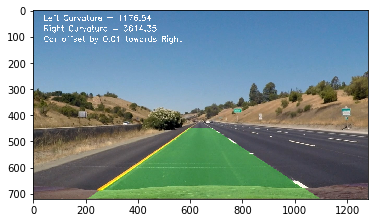

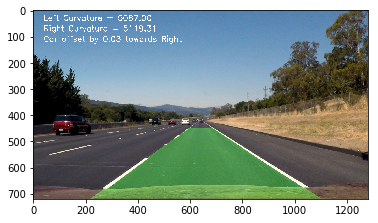

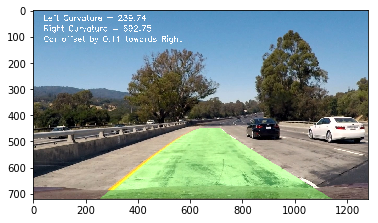

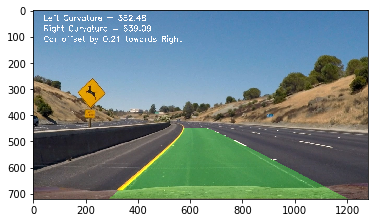

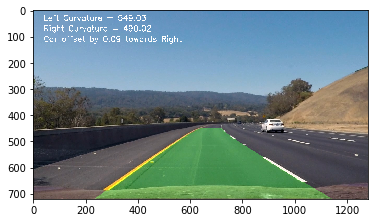

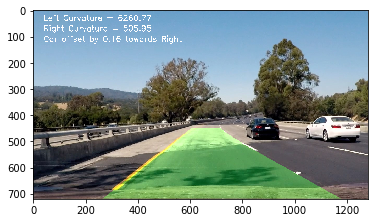

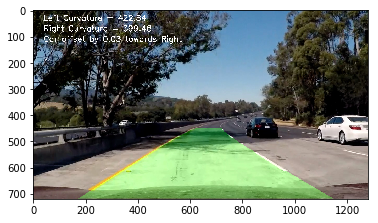

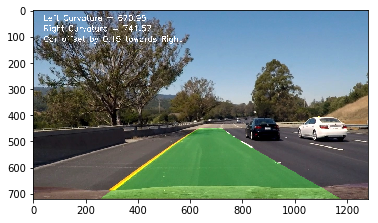

In [39]:
import os

images = glob.glob('test_images/*.jpg')
#print(images)

saveFolder = "output_images"
for fname in images:
        line = LaneDetection()
        img = mpimg.imread(fname)
        laneDetected = line.processImage(img)
        outputImagePath = os.path.join(saveFolder, fname)
        #print(linedImg.shape)
        histogram = np.sum(laneDetected [:600,:],axis=0)
        cv2.imwrite(outputImagePath,cv2.cvtColor(laneDetected,cv2.COLOR_RGB2BGR) )
        plt.figure()
        
        #plt.subplot(2,1,1)
        #plt.plot(histogram)
        #plt.imshow(img)
        #plt.subplot(2,1,2)
        
        plt.imshow(laneDetected)

In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

laneDetect = LaneDetection()
output = 'output/project_video.mp4'

clip2 = VideoFileClip('project_video.mp4')
_clip = clip2.fl_image(laneDetect.processImage)
%time _clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:55<00:00,  9.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

Wall time: 1min 56s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))